In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
import quandl

sns.set()

In [2]:
quandl.ApiConfig.api_key = "ByAzesCp4TpPvjqYi4ay" #Pour faire plus de 50 requetes par jours
start = datetime(2016,1,1)
end = datetime(2017,1,1)
s = "CBS"

In [3]:
df = quandl.get("WIKI/" + s, start_date=start, end_date=end)
df = df.reset_index()
df=df[['Date','Close']]
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.tail()


,Date,Close
247,2016-12-23,64.67
248,2016-12-27,64.85
249,2016-12-28,64.50
250,2016-12-29,64.50
251,2016-12-30,63.62


# Essayer avec une dataframe avec Data . Close Ent1, Close Ent2, Close Ent3, Close Ent4,.....)

In [4]:
#start2 = end
#end2 = datetime(2017,4,1)
#
#df2 = quandl.get("WIKI/" + s, start_date=start2, end_date=end2)
#df2 = df2.reset_index()
#df2=df2[['Date','Open','High','Low','Close','Adj. Close','Adj. Volume']]
#df2.columns=['Date','Open','High','Low','Close','Adj Close','Volume']
#df2.tail()

In [5]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

D:\04.Programme\Anaconda\envs\tensorflow_env\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,0
0,0.180180
1,0.156306
2,0.156757
3,0.121171
4,0.171622


In [6]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [7]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.7
future_day = 5

In [8]:
tf.reset_default_graph()
modelnn = Model(
    0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.


In [9]:
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df_log.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_log.shape[0] -1)
        batch_x = np.expand_dims(
            df_log.iloc[k : index, :].values, axis = 0
        )
        batch_y = df_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.004227055384253617
epoch: 200 avg loss: 0.002488305341103114
epoch: 300 avg loss: 0.0022669550811406226
epoch: 400 avg loss: 0.0029736080917064102
epoch: 500 avg loss: 0.002658362940856023


In [27]:
len(df_log)

302

In [10]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0] = df_log.iloc[0]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_log.iloc[k : k + timestamp], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + timestamp + 1] = out_logits

out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: np.expand_dims(df_log.iloc[upper_b:], axis = 0),
        modelnn.hidden_layer: init_value,
    },
)
init_value = last_state
output_predict[upper_b + 1 : df_log.shape[0] + 1] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1]
date_ori.append(date_ori[-1] + timedelta(days = 1))

In [11]:
for i in range(future_day - 1):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-timestamp:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[df_log.shape[0]] = out_logits[-1]
    df_log.loc[df_log.shape[0]] = out_logits[-1]
    date_ori.append(date_ori[-1] + timedelta(days = 1))

In [12]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [13]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

# Attention Trading Day 

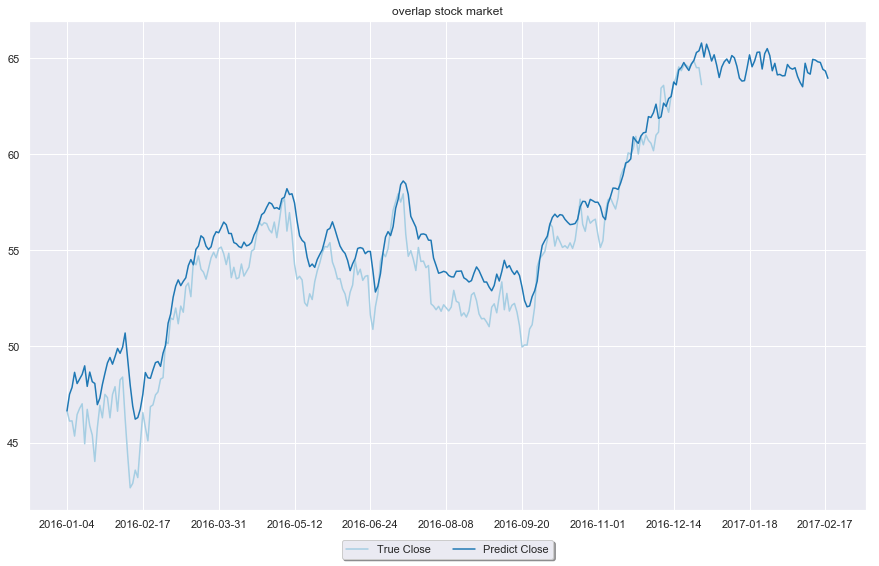

In [22]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'True Close',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'Predict Close',
    color = current_palette[1],
)

box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

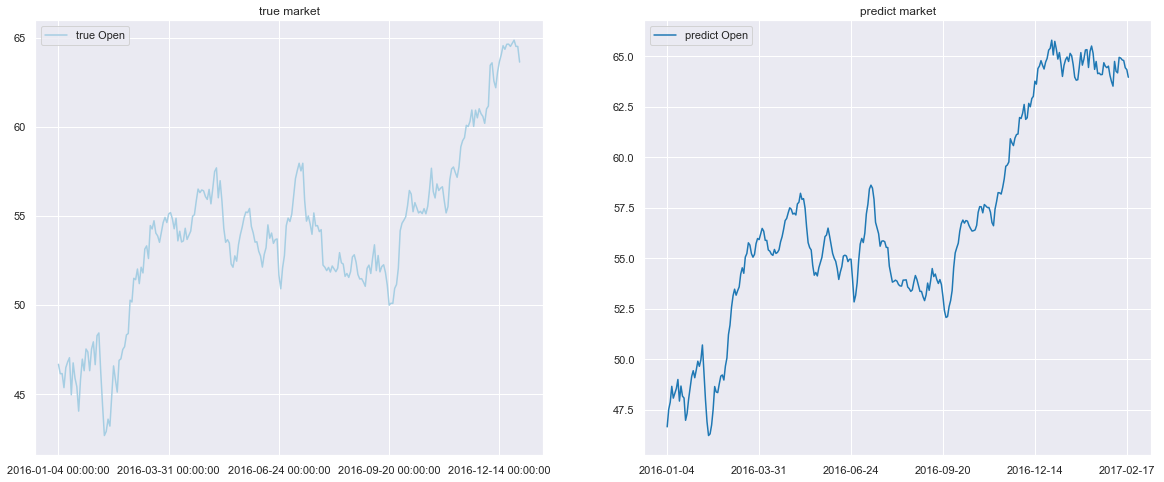

In [19]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
#plt.plot(
#    x_range_original,
#    df.iloc[:, 2],
#    label = 'true High',
#    color = current_palette[2],
#)
#plt.plot(
#    x_range_original,
#    df.iloc[:, 3],
#    label = 'true Low',
#    color = current_palette[4],
#)
#plt.plot(
#    x_range_original,
#    df.iloc[:, 4],
#    label = 'true Close',
#    color = current_palette[6],
#)
#plt.plot(
#    x_range_original,
#    df.iloc[:, 5],
#    label = 'true Adj Close',
#    color = current_palette[8],
#)
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market')
plt.subplot(1, 2, 2)
plt.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
#plt.plot(
#    x_range_future,
#    anchor(df_log[:, 1], 0.5),
#    label = 'predict High',
#    color = current_palette[3],
#)
#plt.plot(
#    x_range_future,
#    anchor(df_log[:, 2], 0.5),
#    label = 'predict Low',
#    color = current_palette[5],
#)
#plt.plot(
#    x_range_future,
#    anchor(df_log[:, 3], 0.5),
#    label = 'predict Close',
#    color = current_palette[7],
#)
#plt.plot(
#    x_range_future,
#    anchor(df_log[:, 4], 0.5),
#    label = 'predict Adj Close',
#    color = current_palette[9],
#)
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market')
plt.show()

In [21]:
df_log

array([[46.65000153],
       [48.378268  ],
       [48.23260498],
       [49.43575072],
       [47.48739956],
       [48.54144719],
       [48.78915386],
       [49.4386327 ],
       [46.85629037],
       [49.41452755],
       [47.66772508],
       [47.98337329],
       [45.87250191],
       [47.65316698],
       [48.73065087],
       [49.17433083],
       [49.69544579],
       [49.70728004],
       [48.73303863],
       [49.86058732],
       [50.32310666],
       [49.39257329],
       [50.28675839],
       [51.43670197],
       [47.97170511],
       [46.64507091],
       [45.80505459],
       [45.54272829],
       [46.38319318],
       [47.17781766],
       [48.28215967],
       [49.77799968],
       [48.10337638],
       [48.31457996],
       [49.20599291],
       [49.54414782],
       [49.27498178],
       [48.71491907],
       [50.34266853],
       [50.46714345],
       [52.36374865],
       [52.15683694],
       [53.44426273],
       [53.70866185],
       [53.78774096],
       [52

In [ ]:
reel = quandl.get("WIKI/" + s, start_date=start2, end_date=end2)

In [ ]:
reel['Close'].plot(grid = True) 

In [ ]:
final=pd.DataFrame()
final2=pd.DataFrame()
final['Close']=df_log[:, 3]
final2['Date']=date_ori

In [ ]:
final3=final2.join(final).set_index('Date')
final3.head()

In [ ]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
x_range_original2 = np.arange(df2.shape[0])


ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)



box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market')
plt.xticks(x_range_future[::30], date_ori[::30])

plt.plot(final3)
plt.show()

In [ ]:
final3=final3.tail(50)

In [ ]:
df3=df2[['Date','Close']]
df3=df3.set_index('Date')
df3.head(5)

In [ ]:
ecart=abs(final3-df3)
ecart=ecart.dropna()

In [ ]:
V=ecart['Close'].mean()
V_percent=V/(df3['Close'][-1])
print(V_percent*100 , "%")

In [ ]:
ecart2=(final3-df3)**2
V2=(ecart2.mean())**(1/2)
V2
V2_percent=V2/(df3['Close'][-1])
print("% Valeur absolue",V2_percent*100 , "%" , "Valeur absolue", V2)

In [ ]:
excel=pd.DataFrame()
excel['True Close']=df3['Close']
excel=excel.join(final3)
excel['Ecart']=ecart['Close']


In [ ]:
excel.head()

In [ ]:
excel2=excel.dropna()

In [ ]:
excel2.to_csv('lstm_16_17_'+s+'.csv')